In [1]:
# import standard libs

from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os


In [2]:
# get project dir

pp = PurePath(Path.cwd()).parts[:]
pdir = PurePath(*pp)
script_dir = pdir / 'src'
viz_dir = pdir / 'report'/'figures'
data_dir = pdir / 'data'
script_dirs = Path(script_dir).glob('./*/')

In [3]:
for sdir in script_dirs:
    print(sdir.as_posix())
    sys.path.append(sdir.as_posix())

In [4]:
# import python scientific stack

import pandas as pd
# import pandas_datareader.data as web
pd.set_option('display.max_rows',100)

from dask import dataframe as dd
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math


In [5]:
# import visual tools

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
plt.rcParams['font.weight'] = 'medium'


In [6]:
blue,green,red,purple,gold,teal = sns.color_palette('colorblind',6)

In [7]:
#import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 777

## Introduction

Ticks, volume,or dollar volume traded as the sampling interval

## Read and Clean Data

A sample of equity tick data, symbol IVE, provided by kibot.com
Download this data to the ./data/raw directory in your local repo

In [8]:
def read_kibot_ticks(fp):
    # read tick data
    cols = list(map(str.lower,['Date','Time','Price','Bid','Ask','Size']))
    df = (pd.read_csv(fp, header = None)
          .rename(columns = dict(zip(range(len(cols)),cols)))
          .assign(dates = lambda df : (pd.to_datetime(df['date']+df['time'],
                                                      format = '%m/%d/%Y%H:%M:%S')))
          
          .assign(v = lambda df: df['size']) # volume
          .assign(dv = lambda df: df['price'] * df['size']) # dollar volume
          .drop(['date','time'],axis = 1)
          .set_index('dates')
          .drop_duplicates())
    return df

In [9]:
infp = PurePath(data_dir/'raw'/'IVE_tickbidask.txt')

In [10]:
df = read_kibot_ticks(infp)



In [11]:
df.head()

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,300,15225.00


In [12]:
outfp = PurePath(data_dir/'interim'/'IVE_tickbidask.parq')
df.to_parquet(outfp)

In [13]:
infp = PurePath(data_dir/'interim'/'IVE_tickbidask.parq')
df = pd.read_parquet(infp)

## Remove Obvious Price Errors in Tick Data

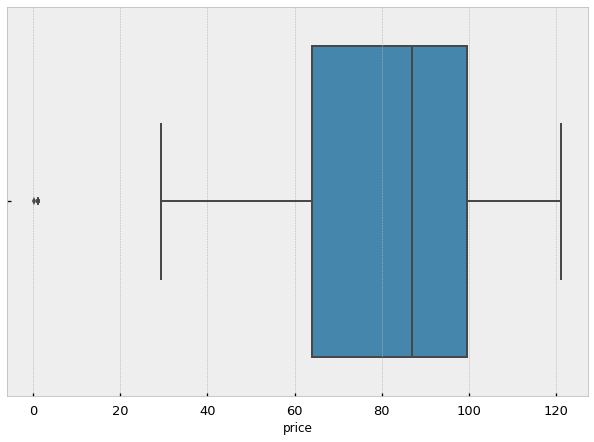

In [14]:
sns.boxplot(df.price)

In [15]:
@jit(nopython=True)
def mad_outlier(y, thresh=3.):
    '''
    compute outliers based on mad
    # args
        y: assumed to be array with shape (N,1)
        thresh: float()
    # returns
        array index of outliers
    '''
    # This function is an approximation of MAD Approach
    # @jit can speed up the calculation but may not be applicable to the orginal MAD Approach
    median = np.median(y)
    print(median)
    diff = np.sum((y - median)**2, axis=-1) # this line is complicated
    diff = np.sqrt(diff)
    print(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    print(modified_z_score)
    
    return modified_z_score > thresh

In [16]:
mad = mad_outlier(df.price.values.reshape(-1,1))



86.96
[36.17 36.25 36.21 ... 29.26 29.26 29.26]
[1.41225268 1.41537627 1.41381447 ... 1.14245268 1.14245268 1.14245268]


In [17]:
df.loc[mad]

,price,bid,ask,size,v,dv
dates,,,,,,
2010-05-06 14:49:07,0.11,0.10,44.03,500,500,55.0
2010-05-06 14:53:30,1.10,1.10,30.28,2600,2600,2860.0
2010-05-06 14:55:32,1.10,1.10,50.57,300,300,330.0
2010-05-06 14:55:32,1.10,1.10,50.57,100,100,110.0
2010-05-06 14:55:32,1.10,1.00,50.57,200,200,220.0
2010-05-06 14:55:32,1.10,1.00,50.57,700,700,770.0
2010-05-06 14:55:32,1.10,1.00,50.57,1200,1200,1320.0
2010-05-06 14:55:32,1.10,0.55,50.57,500,500,550.0
2010-05-06 14:55:32,1.10,0.55,50.57,100,100,110.0


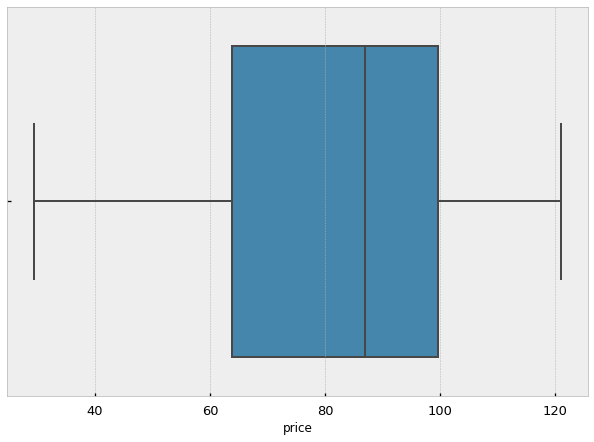

In [18]:
sns.boxplot(df.loc[~mad].price)

In [19]:
df = df.loc[~mad] # drop the outliner

df.head()

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,300,15225.00


In [20]:
outfp = PurePath(data_dir/'processed'/'clean_IVE_fut_prices.parq')
df.to_parquet(outfp)

In [21]:
infp = PurePath(data_dir/'processed'/'clean_IVE_fut_prices.parq')
df = pd.read_parquet(infp)

## Bars

In [22]:
def general_bars(df,column,m,tick = False):
    """
    Compute tick bars
    
    # Args:
        df: pd.DataFrame()
        column: name for price data
        m: int(), threshold value for ticks
    # Returns:
        idx: list of indices
    """
    t = df[column]
    ts = 0
    idx = []
    # for i, x in enumerate(tqdm(t)):
    if tick: # if tick bar
        for i,x in enumerate(t):
            ts += 1 # each data plus 1
            if ts >= m:
                idx.append(i)
                ts = 0
                # continue
    else: # if not tick bar
        for i,x in enumerate(t):
            ts += x # each data plus volume/dollar volume
            if ts >= m:
                idx.append(i)
                ts = 0
                # continue
    return idx

def general_bar_df(df,column,m, tick = False):
    idx = general_bars(df, column, m, tick)
    return df.iloc[idx].drop_duplicates()

In [23]:
def tick_bars(df,price_column,m):
    return general_bars(df,price_column,m, tick = True)

def volume_bars(df,volume_column,m):
    return general_bars(df,volume_column,m)

def dollar_bars(df,dollar_column,m):
    return general_bars(df,dollar_column,m)



def tick_bar_df(df,tick_column,m):
    return general_bar_df(df,tick_column,m,tick = True)

def volume_bar_df(df,volume_column,m):
    return general_bar_df(df,volume_column,m)

def dollar_bar_df(df,dollar_column,m):
    return general_bar_df(df,dollar_column,m)


## Tick Bars

There are many ways to choose M, or the threshold value for smapling prices
One way is based on ratios of total dollar value/volume traded vs. number of ticks

The rest of the notebook uses an arbitrary but sensible M value.


In [24]:
n_ticks = df.shape[0]

volume_ratio = (df.v.sum()/n_ticks).round()
dollar_ratio = (df.dv.sum()/n_ticks).round()

print(f'num ticks: {n_ticks:,}')
print(f'volume ratio: {volume_ratio}')
print(f'volume ratio: {dollar_ratio}')

num ticks: 1,416,200
volume ratio: 548.0
volume ratio: 46524.0


In [25]:
tick_M = 100 # arbitrary
print(f'tick threshold: {tick_M:,}')
tidx = tick_bars(df,'price',tick_M)
tidx[:10]

tick threshold: 100


[99, 199, 299, 399, 499, 599, 699, 799, 899, 999]

In [26]:
df.iloc[tidx].shape, df.shape

((14162, 6), (1416200, 6))

Dataset is large so select smaller example for quick exploration

In [27]:
tick_df = tick_bar_df(df,'price',tick_M)

In [28]:
tick_df.shape

(14162, 6)

In [29]:
def select_sample_data(ref,sub,price_col,date):
    """
    select a sample of data based on data, assumes datatimeindex
    
    # args
        ref: pd.DataFrame containing all ticks
        sub: subordinated pd.DataFrame of prices
        price_col: str(), price colume
        date: str(), date to select
    
    # returns
        xdf: ref pd.Series
        xtdf: subordinated pd.Series
    """
    
    xdf = ref[price_col].loc[date]
    xtdf = sub[price_col].loc[date]
    
    return xdf, xtdf

In [30]:
## try different dates to see how the quantity of tick bars changes

xDate = '2009-10-01'

xdf, xtdf = select_sample_data(df,tick_df,'price',xDate)

xdf.shape, xtdf.shape

((1466,), (15,))

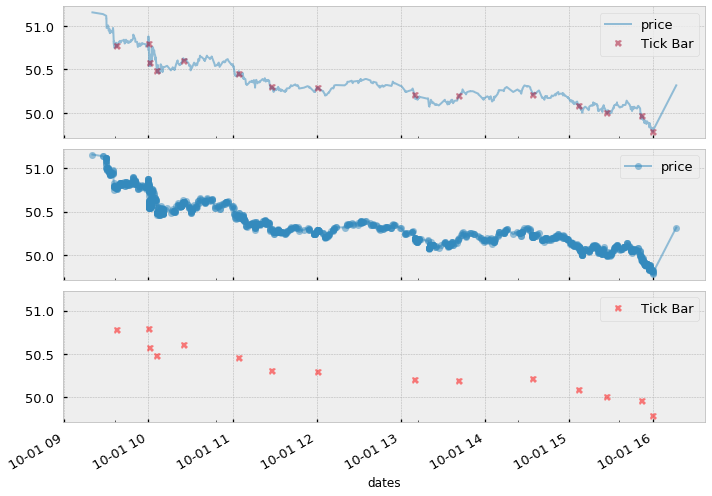

In [31]:
def plot_sample_data(ref, sub, bar_type, *args, **kwds):
    f, axes = plt.subplots(3,sharex=True, sharey=True, figsize=(10,7))
    
    ref.plot(*args, **kwds, ax=axes[0], label='price')
    sub.plot(*args, **kwds, ax=axes[0], marker='X', ls='', label=bar_type)
    axes[0].legend()
    
    ref.plot(*args, **kwds, ax=axes[1], marker='o', label='price')
    sub.plot(*args, **kwds, ax=axes[2], marker='X', ls='', 
             color = 'r', label=bar_type)
    
    for ax in axes[1:]:ax.legend()
    
    plt.tight_layout()
    
    return

plot_sample_data(xdf, xtdf, 'Tick Bar', alpha = 0.5, markersize = 7)
        

    

## Bonus Exercise: Make OHLC Bars from Custom Bars

Extract tick_df.price and df.price into two pandas series

In [32]:
sub = tick_df.price
ref = df.price

The function below creates the OHLC dataframe by:

1. Iterating over the subordinated series' indexes extracting idx and idx+1 period
2. Selecting the same date period from the reference series
3. Extracting the max, min prices from the reference series
4. Combining the o,h,l,c and start and end timestamps into a row
5. Returning the aggregated rows as a pandas dataframe

In [33]:
def get_ohlc(ref,sub):
    """
    fn: get ohlc from custom
    
    # args
        ref: reference pandas series with all prices
        sub: custom tick pandas series
    
    # returns
        tick_df: dataframe with ohlc values
    """
    ohlc = []
    for i in tqdm(range(sub.index.shape[0]-1)):
        start, end = sub.index[i], sub.index[i+1]
        tmp_ref = ref.loc[start:end]
        max_px, min_px = tmp_ref.max(), tmp_ref.min()
        o, h, l, c = sub.iloc[i], max_px, min_px, sub.iloc[i+1]
        ohlc.append((end, start, o, h, l,c))
    cols = ['end','start','open','high','low','close']
    return (pd.DataFrame(ohlc,columns=cols))


In [34]:
## uncomment below to run (takes about 5-6min)

tick_bars_ohlc = get_ohlc(ref,sub)
tick_bars_ohlc.head()


100%|██████████| 14161/14161 [00:03<00:00, 4251.83it/s]


,end,start,open,high,low,close
0,2009-09-28 10:02:52,2009-09-28 09:53:14,51.1500,51.260,51.0800,51.2500
1,2009-09-28 10:22:24,2009-09-28 10:02:52,51.2500,51.290,51.1873,51.1961
2,2009-09-28 10:38:44,2009-09-28 10:22:24,51.1961,51.380,51.1961,51.3650
3,2009-09-28 11:24:29,2009-09-28 10:38:44,51.3650,51.365,51.2700,51.3200
4,2009-09-28 11:52:17,2009-09-28 11:24:29,51.3200,51.436,51.3200,51.4300


In [35]:
outfp = PurePath(data_dir/'processed'/'tick_bars_ohlc.parq')
tick_bars_ohlc.to_parquet(outfp)

## Volume Bars

In [36]:
volume_M = 10000 # arbitrary
print(f"Volume threshold: {volume_M:,}")

Volume threshold: 10,000


In [37]:
v_bar_df = volume_bar_df(df,'v',volume_M)

In [38]:
v_bar_df.head()

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:44:09,50.91,50.91,50.92,1100,1100,56001.0
2009-09-28 09:46:35,51.07,51.05,51.07,3300,3300,168531.0
2009-09-28 09:52:47,51.13,51.13,51.14,2000,2000,102260.0
2009-09-28 09:54:36,51.13,51.11,51.13,400,400,20452.0
2009-09-28 09:54:41,51.14,51.13,51.14,700,700,35798.0


In [39]:
xDate = '2009-10-1'

xdf, xtdf = select_sample_data(df, v_bar_df, 'price', xDate)
print(f'xdf shape: {xdf.shape},xtdf shape: {xtdf.shape}')

xdf shape: (1466,),xtdf shape: (48,)


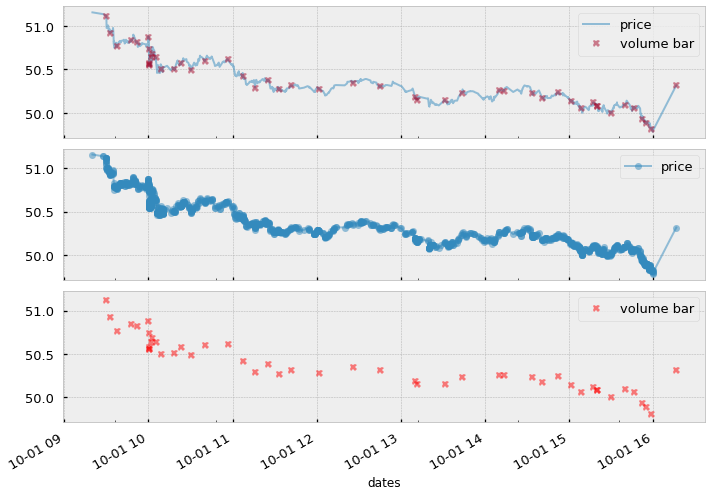

In [40]:
plot_sample_data(xdf,xtdf,'volume bar', alpha = 0.5, markersize = 7)

## Dollar Value Bars

In [41]:
dollar_M = 1000000 # arbitrary
print(f'dollar threshold: {dollar_M:,}')
dv_bar_df = dollar_bar_df(df, 'dv', dollar_M)
dv_bar_df.head()

dollar threshold: 1,000,000


,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:46:35,51.07,51.05,51.07,900,900,45963.0
2009-09-28 09:53:49,51.14,51.13,51.14,2000,2000,102280.0
2009-09-28 09:55:26,51.14,51.11,51.14,100,100,5114.0
2009-09-28 10:02:52,51.25,51.24,51.26,4300,4300,220375.0
2009-09-28 10:10:21,51.29,51.28,51.29,4500,4500,230805.0


In [42]:
xDate = '2009-10-01'
xdf, xtdf = select_sample_data(df,dv_bar_df,'price',xDate)
print(f"xdf shape: {xdf.shape}, xtdf shape: {xtdf.shape}")

xdf shape: (1466,), xtdf shape: (26,)


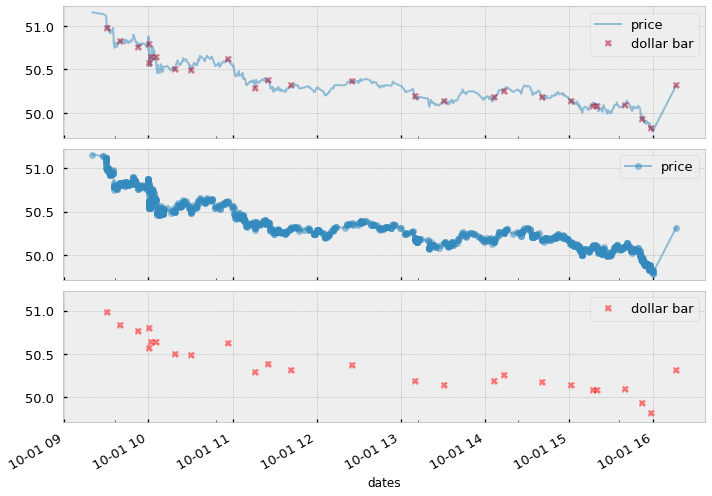

In [43]:
plot_sample_data(xdf,xtdf,'dollar bar',alpha=0.5,markersize=7)

## Analysing the Bars

### Count Quantity of Bars by Each Bar Type (Weekly)

In [44]:
def count_bars(df, price_col = 'price'):
    return df.groupby(pd.TimeGrouper('1W'))[price_col].count()

def scale(s):
    return (s - s.min())/(s.max()-s.min())

In [45]:
# count series
# scale to compare `apples to apples`

tc = scale(count_bars(tick_df))
vc = scale(count_bars(v_bar_df))
dc = scale(count_bars(dv_bar_df))
dfc = scale(count_bars(df))

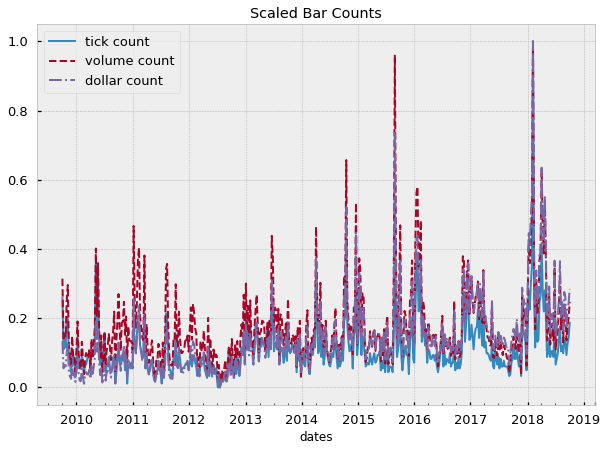

In [46]:
# plot time series of count

f, ax = plt.subplots(figsize=(10,7))

tc.plot(ax=ax, ls='-', label = 'tick count')
vc.plot(ax=ax, ls='--',label = 'volume count')
dc.plot(ax=ax, ls='-.',label = 'dollar count')

ax.set_title('Scaled Bar Counts')
ax.legend()

## Which Bar Type has the most stable counts

In [47]:
print(f'tc std:{tc.std():.2%}, \
        vc std:{vc.std():.2%}, \
        dc std:{dc.std():.2%}')

tc std:8.00%,         vc std:11.52%,         dc std:10.96%


In [48]:
bar_types = ['tick','volume','dollar','df']
bar_std = [tc.std(), vc.std(), dc.std(), dfc.std()]
counts = (pd.Series(bar_std, index = bar_types))
counts.sort_values()

tick      0.080032
df        0.080290
dollar    0.109594
volume    0.115203
dtype: float64

Actually, it does not make sense....

What I understand is:
1. time bar is almost fixed
2. tick only reflects the change of the price but nothing more
3. dollar and volume reflect not only the price change but also the strength of trading activity

Therefore, time bars and tick bars are more stable

## Which Bar Type has the lowest serial correlation?

In [49]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index = s.index[1:]))

In [50]:
tr = returns(tick_df.price)
vr = returns(v_bar_df.price)
dr = returns(dv_bar_df.price)
df_ret = returns(df.price)

bar_returns = [tr, vr, dr, df_ret]

In [51]:
def get_test_stats(bar_types, bar_returns, test_func, 
                   *args, **kwds):
    dct = {bar:(int(bar_ret.shape[0]),test_func(bar_ret, *args, **kwds))
           for bar, bar_ret in zip(bar_types, bar_returns)}
    df = (pd.DataFrame.from_dict(dct)
          .rename(index={0:'sample size',1:f'{test_func.__name__}_stat'}).T)
    
    return df

In [52]:
autocorrs = get_test_stats(bar_types, bar_returns, pd.Series.autocorr)
display(autocorrs.sort_values('autocorr_stat'),
        autocorrs.abs().sort_values('autocorr_stat'))

,sample size,autocorr_stat
dollar,50765.0,-0.123141
df,1416199.0,-0.092242
volume,60264.0,-0.017485
tick,14161.0,0.061935


,sample size,autocorr_stat
volume,60264.0,0.017485
tick,14161.0,0.061935
df,1416199.0,0.092242
dollar,50765.0,0.123141


In [53]:
def plot_autocorr(bar_types, bar_returns):
    f, axes = plt.subplots(len(bar_types),figsize=(10,7))
    
    for i, (bar,typ) in enumerate(zip(bar_returns, bar_types)):
        sm.graphics.tsa.plot_acf(bar, lags=120, ax = axes[i],
                                 alpha = 0.05, unbiased = True, fft = True,
                                 zero = False,
                                 title = f'{typ} AutoCorr')
    plt.tight_layout()
        
def plot_hist(bar_types, bar_ret):
    f, axes = plt.subplots(len(bar_types), figsize=(10,6))
    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        g = sns.distplot(bar, ax=axes[i], kde = False, label = typ)
        g.set(yscale='log')
        axes[i].legend()
    plt.tight_layout()

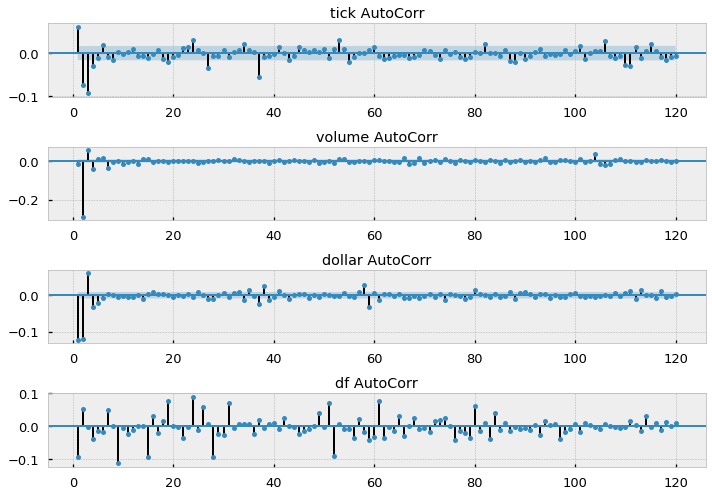

In [54]:
plot_autocorr(bar_types, bar_returns)

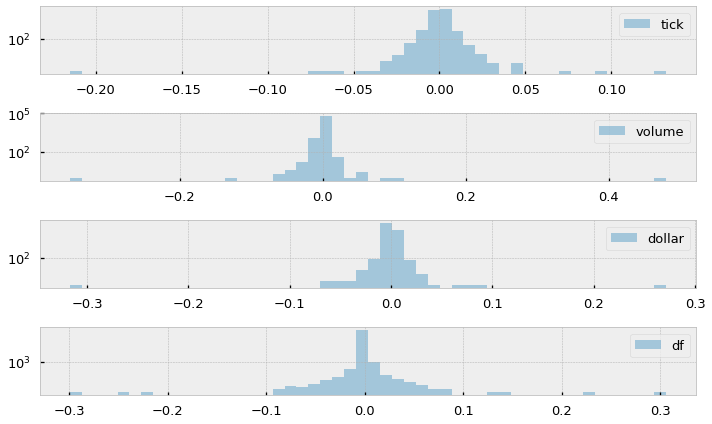

In [55]:
 plot_hist(bar_types, bar_returns)

## Partition Bar Series into Monthly, Compute Variance of Returns, and Variance of Variance

In [56]:
def partition_monthly(s):
    return s.resample('1M').var()

In [57]:
tr_rs = partition_monthly(tr)
vr_rs = partition_monthly(vr)
dr_rs = partition_monthly(dr)
df_ret_rs = partition_monthly(df_ret)

monthly_vars = [tr_rs, vr_rs, dr_rs, df_ret_rs]

In [58]:
get_test_stats(bar_types, monthly_vars, np.var).sort_values('var_stat')

,sample size,var_stat
df,110.0,5.295761e-12
tick,110.0,1.898539e-09
dollar,110.0,2.099271e-09
volume,110.0,2.710183e-09


## Compute Jarque-Bera Test, which has the lowest test statistics?

In [59]:
def jb(x, test=True):
    #np.random.seed(12345678)
    if test: return stats.jarque_bera(x)[0]
    return stats.jarque_bera(x)[1]

get_test_stats(bar_types, bar_returns, jb).sort_values('jb_stat')

,sample size,jb_stat
tick,14161.0,1.302361e+08
dollar,50765.0,5.404986e+10
volume,60264.0,3.277633e+11
df,1416199.0,2.067849e+14


## Compute Shapiro-Wilk Test

Shapiro-Wilk test statistic - the larger the better

In [60]:
def shapiro(x, test = True):
    if test: return stats.shapiro(x)[0]
    return stats.shapiro(x)[1]

get_test_stats(bar_types, bar_returns, shapiro).sort_values('shapiro_stat')[::-1]

,sample size,shapiro_stat
tick,14161.0,0.655457
dollar,50765.0,0.406283
volume,60264.0,0.282896
df,1416199.0,0.176869


## Compare Serial Correlation between Dollar and Dollan Imbalance Bars

1. Compute the sequence $b_{t=1,...,T}$
2. Compute the imbalance $\theta$ at $T$: $\theta_T = \sum_{t=1}^T b_t v_t$
3. $E_0[T]$: the expected size of the tick bar. Compute the expected value of  as expoential weighted moving average of previous $E_0[T]$ values
4. Compute the expected value of $\theta_T$ as exponential weighted moving average of $b_t v_t$ values
5. For each index:
    - compute $ \lvert \theta_t \rvert \ge E_0[T] \lvert 2 v^+ - E_0[v_t] \rvert $
    - if the condition is met, capture the quantity of ticks
    - reset tick count
    - continue

In [74]:
@jit(nopython = True)
def numba_isclose(a,b,rel_tol = 1e-09, abs_tol=0.0):
    # rel_tol: relative tolerance
    # abs_tol: absolute tolerance
    return np.fabs(a-b) <= np.fmax(rel_tol*np.fmax(np.fabs(a),np.fabs(b)),abs_tol)

In [76]:
@jit(nopython=True)

def bt(p0,p1,bs):
    if numba_isclose((p1-p0),0.0,abs_tol=0.001):
        return bs[-1]
    else: return np.abs(p1-p0)/(p1-p0)

In [91]:
#@jit(nopython=True)

def get_imbalance(t):
    """Noted that this function return a list start from the 2nd obs"""
    bs = np.zeros_like(t)
    for i in np.arange(1,bs.shape[0]):
        bs[i-1] = bt(t[i-1],t[i],bs[:i-1])
    return bs[:-1] # remove the last value

In [93]:
## Noted that get_imbalance return the tick bars from the 2nd obs
## amazingly the date, dv, and ticks are matched, lol
tidx = get_imbalance(df.price.values)*df.dv.iloc[1:]
tidx.head()

dates
2009-09-28 09:30:00   -32352.98
2009-09-28 09:31:32     5075.00
2009-09-28 09:31:33     5075.00
2009-09-28 09:31:50    15225.00
2009-09-28 09:31:51    15225.00
Name: dv, dtype: float64

In [95]:
# window size
wndo = tidx.shape[0] // 1000
print(f'window size:{wndo:,.2f}')

window size:1,416.00


In [97]:
## Expected value of bs approximated by ewm
E_bs = tidx.ewm(wndo).mean()

In [99]:
## What is E_T???
## in this implementation E_T is ewm of index values
E_T = pd.Series(range(tidx.shape[0]),index=tidx.index).ewm(wndo).mean()

In [100]:
df0 = (pd.DataFrame().assign(bs=tidx)
       .assign(E_T=E_T)
       .assign(E_bs=E_bs)
       .assign(absMul = lambda df: df.E_T*np.abs(df.E_bs))
       .assign(absTheta = tidx.cumsum().abs()))

In [101]:
df0.head()

,bs,E_T,E_bs,absMul,absTheta
dates,,,,,
2009-09-28 09:30:00,-32352.98,0.000000,-32352.980000,0.000000,32352.98
2009-09-28 09:31:32,5075.00,0.500176,-13632.384285,6818.598141,27277.98
2009-09-28 09:31:33,5075.00,1.000471,-7392.186750,7395.665836,22202.98
2009-09-28 09:31:50,15225.00,1.500882,-1731.901047,2599.379899,6977.98
2009-09-28 09:31:51,15225.00,2.001412,1664.269246,3330.888324,8247.02


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f65f3e66b00>,
      dtype=object)

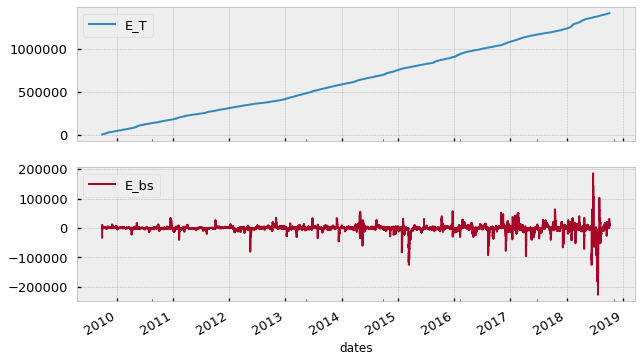

In [106]:
df0[['E_T','E_bs']].plot(subplots=True,figsize=(10,6))

In [107]:
display(df0.describe()/1000)

,bs,E_T,E_bs,absMul,absTheta
count,1416.199000,1416.199000,1416.199000,1.416199e+03,1.416199e+03
mean,-0.868396,706.685330,-0.876148,5.471895e+06,3.240696e+05
std,678.087064,408.817559,12.981937,1.418429e+07,3.164342e+05
min,-244194.944400,0.000000,-226.301289,0.000000e+00,3.537070e-01
25%,-19.388268,352.633500,-2.780387,4.454746e+05,4.764046e+04
50%,-4.959100,706.683000,-0.075123,1.636679e+06,1.295138e+05
75%,19.188733,1060.732500,2.665891,4.849096e+06,5.892219e+05
max,289491.800000,1414.782000,185.312974,3.116753e+08,1.401899e+06


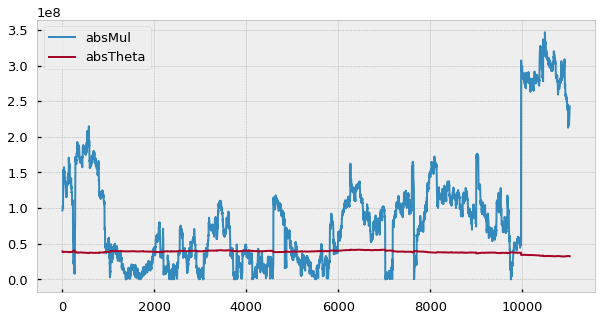

In [110]:
(df0.loc['2010-06',['absMul','absTheta']]
 .reset_index(drop=True)
 .plot(figsize=(10,5)))

In [111]:
def test_t_abs(absTheta,t,E_bs):
    """
    Bool function to test inequality
    * row is assumed to come from df.itertuples()
    - absTheta: float(), row.absTheta
    - t: pd.Timestamp
    - E_bs: float, row.E_bs
    """
    return (absTheta >= t*E_bs)

def agg_imalance_bars(df):
    """
    Implements the accumulation logic
    """
    start = df.index[0]
    bars = []
    for row in df.itertuples():
        t_abs = row.absTheta
        rowIdx = row.Index
        E_bs = row.E_bs
        
        t = df.loc[start:rowIdx].shape[0]
        if t<1: t = 1 # if t less than 1, set equal to 1
        if test_t_abs(t_abs,t,E_bs):
            bars.append((start,rowIdx,t))
            start = rowIdx
    return bars
    

In [112]:
bars = agg_imalance_bars(df0)
test_imb_bars = (pd.DataFrame(bars,columns=['start','stop','Ts'])
                 .drop_duplicates())
test_imb_bars.head()


,start,stop,Ts
0,2009-09-28 09:30:00,2009-09-28 09:30:00,1
1,2009-09-28 09:30:00,2009-09-28 09:31:32,2
2,2009-09-28 09:31:32,2009-09-28 09:31:33,2
3,2009-09-28 09:31:33,2009-09-28 09:31:50,2
4,2009-09-28 09:31:50,2009-09-28 09:31:51,2


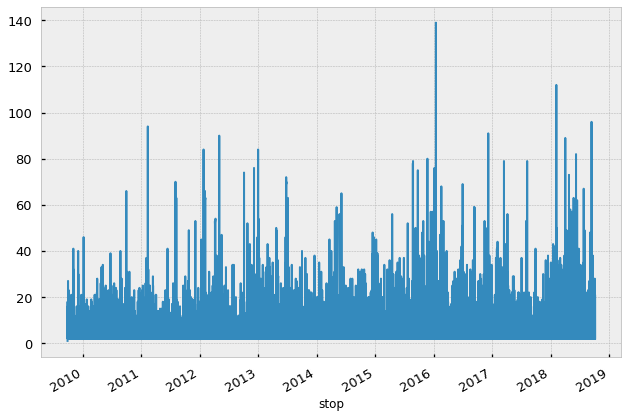

In [113]:
test_imb_bars.set_index('stop')['Ts'].plot();

In [114]:
dvImbBars = df.price.loc[test_imb_bars.stop].drop_duplicates()

In [116]:
dvImbBars.head()

dates
2009-09-28 09:30:00    50.7900
2009-09-28 09:30:00    50.7100
2009-09-28 09:31:32    50.7500
2009-09-28 09:32:06    50.7800
2009-09-28 09:32:56    50.8226
Name: price, dtype: float64

In [117]:
dvBar = dv_bar_df.price
dvBar.head()

dates
2009-09-28 09:46:35    51.07
2009-09-28 09:53:49    51.14
2009-09-28 09:55:26    51.14
2009-09-28 10:02:52    51.25
2009-09-28 10:10:21    51.29
Name: price, dtype: float64

In [118]:
dr = returns(dv_bar_df.price)

In [119]:
drImb = returns(dvImbBars)

In [120]:
bar_types = ['dvBar','dvImb']
bar_rets = [dr,drImb]

get_test_stats(bar_types, bar_rets, pd.Series.autocorr)

,sample size,autocorr_stat
dvBar,50765.0,-0.123141
dvImb,264610.0,-0.075539


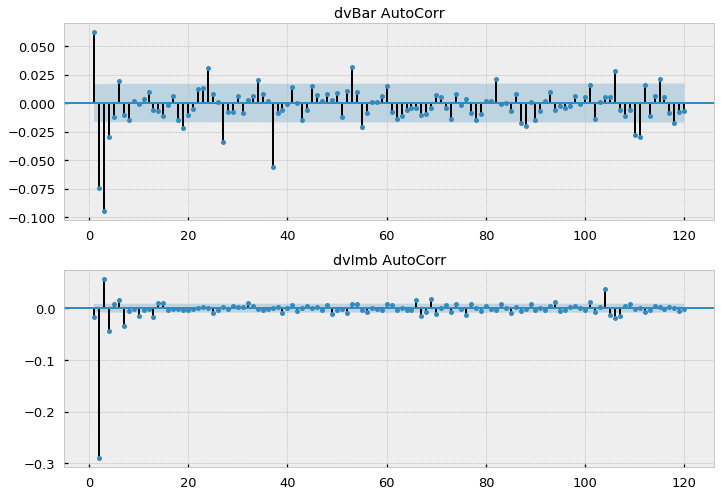

In [121]:
plot_autocorr(bar_types,bar_returns)

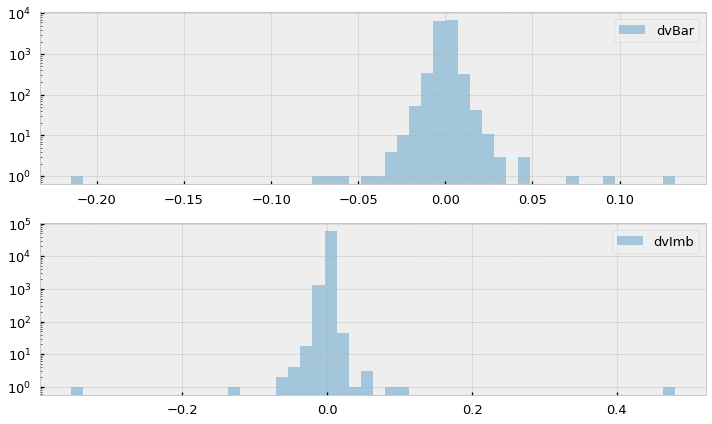

In [122]:
plot_hist(bar_types,bar_returns)

In [123]:
jbs = get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat')
shaps = (get_test_stats(bar_types,bar_returns,shapiro)
         .sort_values('shapiro_stat')[::-1])

display(jbs,shaps)

,sample size,jb_stat
dvBar,14161.0,1.302361e+08
dvImb,60264.0,3.277633e+11


,sample size,shapiro_stat
dvBar,14161.0,0.655457
dvImb,60264.0,0.282896
